In [12]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [13]:
import os

out_dir = os.path.join('figures', '4classes')
os.makedirs(out_dir, exist_ok=True)

In [14]:
K = 10         #Index of the instance you want to test in the test set
N_class = 4    #Number of class, the dimension of the simplex is therefore N_class-1
N_feat  = 6    #In this example, since the number of feature of the digit dataset is quite large (64), we propose to reduce it with a PCA

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Reduce the number of feature to N_feat with a PCA
pca = PCA(n_components=N_feat)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)

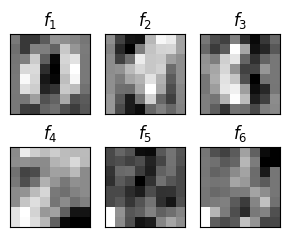

In [15]:
fig, ax_list = plt.subplots(nrows=2, ncols=int(N_feat/2), figsize=(3, 2.5))
for i, (c, ax) in enumerate(zip(pca.components_, ax_list.flatten())):
    ax.set_title(f'$f_{i+1}$')
    ax.imshow(c.reshape([8,8]), cmap='grey')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(out_dir, 'ex_eq4_pca_components.pdf'))

In [16]:
#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

In [17]:
#sbpmatrix = np.array([[1,-1,0,0],[0,0,1,-1],[1,1,-1,-1]])
#basis = sbp_basis(sbpmatrix)
#root = create_tree_from_sbp(sbpmatrix, N_class)

##Visualise the tree using graphviz
#graph = init_graph()
#build_graph(root, graph)
#graph       #plot the bifurcation tree

In [18]:
# Explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class,
                             names_classes=['0','1','2','3'], 
                             names_features=['1st prin. comp.','2nd prin. comp.','3rd prin. comp.','4th prin. comp.','5th prin. comp.','6th prin. comp.'])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

[[ 1. -1.  0.  0.]
 [ 1.  1. -1.  0.]
 [ 1.  1.  1. -1.]]
True label of the tested instance: 0
Prediction on the simplex: [[9.95184588e-01 6.17119945e-04 2.36318420e-03 1.83510820e-03]]
Prediction in the ILR space: [5.22242206 1.91885534 1.57585908]
Sum of the shapley composition and the base distribution in the ILR space: [5.22242201 1.91885527 1.57585905]


In [19]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()


List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 1st prin. comp.: 4.3689174
	 3rd prin. comp.: 1.6254994
	 2nd prin. comp.: 0.8627262
	 4th prin. comp.: 0.3448546
	 6th prin. comp.: 0.163203
	 5th prin. comp.: 0.1391143

Projection of the Shapley compositions on the class vectors:
		1st prin. comp.	2nd prin. comp.	3rd prin. comp.	4th prin. comp.	5th prin. comp.	6th prin. comp.	
0:        	4.2353213	0.4484568	0.9460146	0.2650412	0.1173047	0.1374502	
1:        	-1.1819588	-0.8441751	0.0436900	-0.1739847	-0.0954868	-0.1157560	
2:        	-2.3791586	0.1845609	0.5386824	0.1186410	0.0257488	0.0277941	
3:        	-0.6742038	0.2111574	-1.5283869	-0.2096975	-0.0475667	-0.0494883	

Cosine between each Shapley compositions:
		1st prin. comp.	2nd prin. comp.	3rd prin. comp.	4th prin. comp.	5th prin. comp.	6th prin. comp.	
1st prin. comp.:	1.0000000	0.4607785	0.3911617	0.5910286	0.7163300	0.7217921	
2nd prin. comp.:	0.4607785	1.0000000	0.0877382	0.6134573

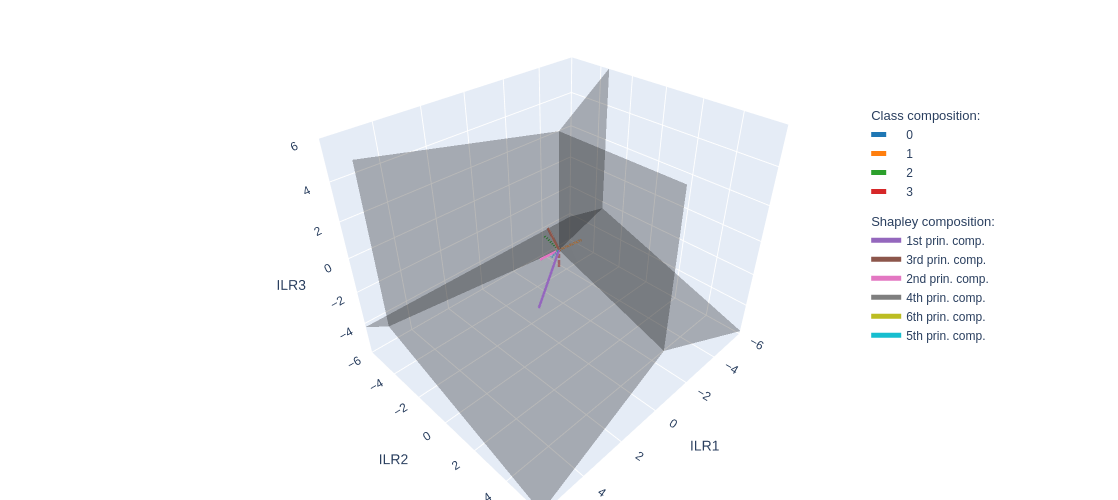

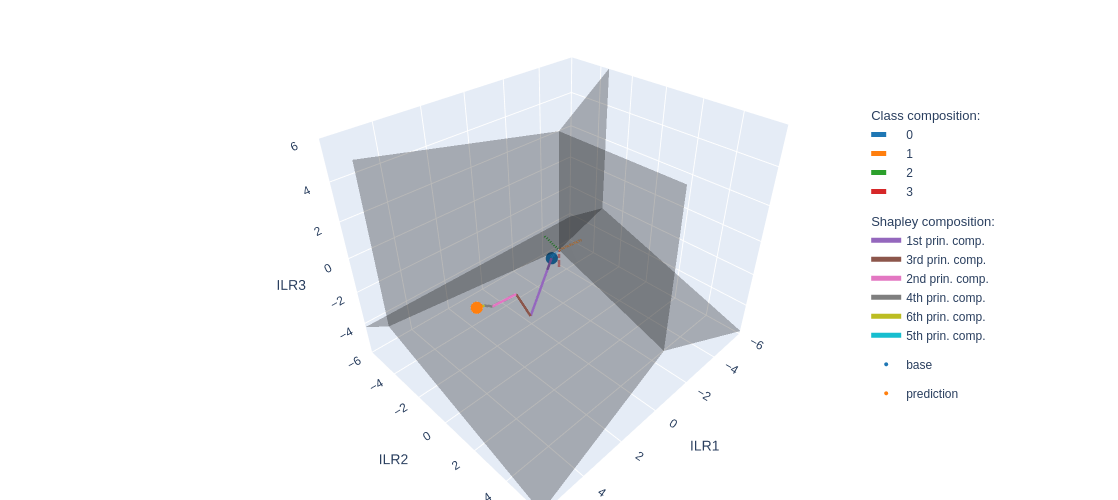

In [20]:
#PLOT the 3D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]

#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2, 3], lim=6, figsize=500, sort=True)
fig.write_image(os.path.join(out_dir, 'ex_eq4_ilrplot.pdf'))

fig = explainer.plot_ilr_space(balances=[1, 2, 3], shapley_sum=True, lim=6, figsize=500, sort=True)
fig.write_image(os.path.join(out_dir, 'ex_eq4_ilrplotsum.pdf'))

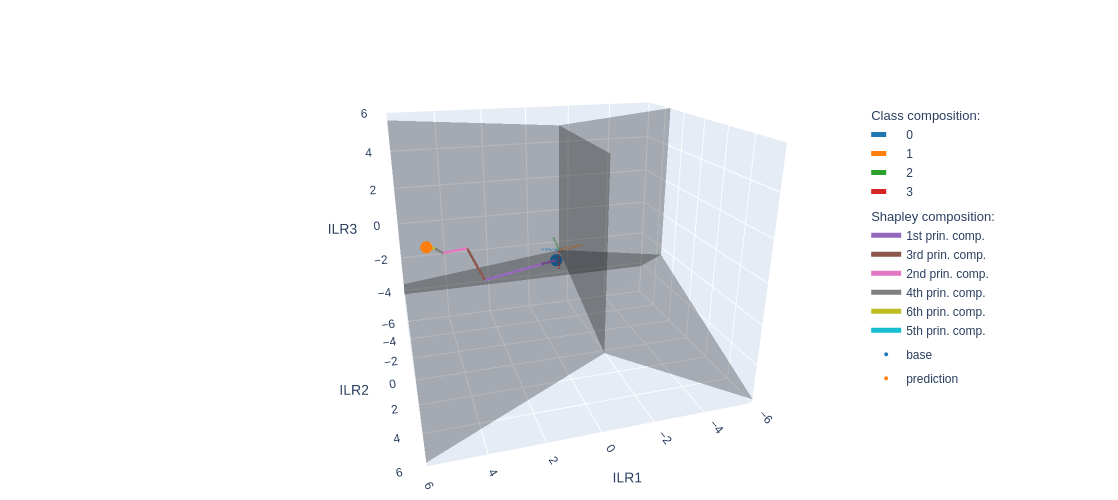

In [21]:
#adjust visulisation angle

camera = dict(
    eye=dict(x=0.6, y=2, z=0.8)
)
fig.update_layout(scene_camera=camera, legend_tracegroupgap=5, legend = dict(font = dict(size = 12)))
fig.show()

fig.write_image(os.path.join(out_dir, 'ex_eq4_ilrplotsum.pdf'), scale=1.5)

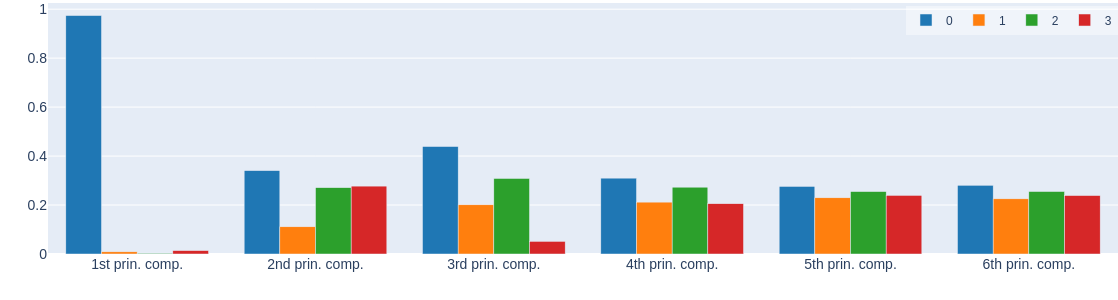

In [22]:
#Plot the Shapley compositions as histograms

fig = explainer.shapley_histogram(figheight=300)
fig.write_image(os.path.join(out_dir, 'ex_eq4_histo.pdf'))

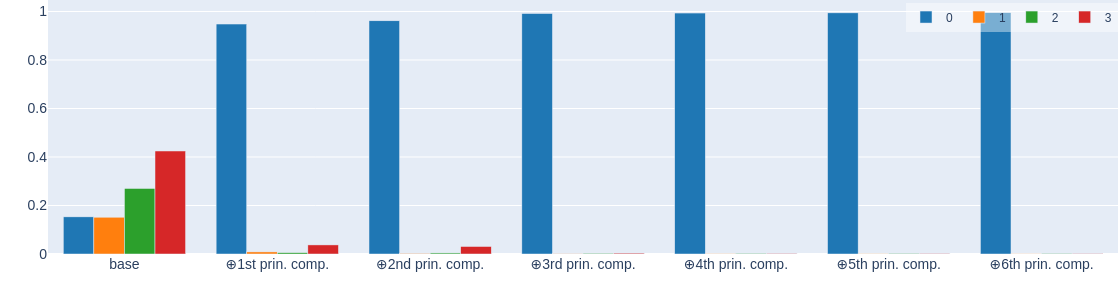

In [23]:
fig = explainer.shapley_histogram_from_base_to_pred(figheight=300)
